## Тестовое задание на позицию аналитика данных

Для выполнения задания создадим две таблицы в БД и заполним её некоторыми данными.

```sql
CREATE TABLE users (
    user_id SERIAL PRIMARY KEY,
    user_name VARCHAR(255),
    first_action_date DATE,
    status VARCHAR(50)
);

CREATE TABLE sales (
    user_id INT,
    deal_amount DECIMAL(10, 2),
    deal_date DATE,
    FOREIGN KEY (user_id) REFERENCES users(user_id)
);
```
Подключимся к БД.

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
host = "localhost" 
dbname = "postgres"
user = "postgres" 
password = "" 
port = 5432 

connection = psycopg2.connect(
        host=host,
        dbname=dbname,
        user=user,
        password=password,
        port=port
)

Для того, чтоб получить общую картину по LTV, сгруппируем пользователей по когортам в зависимости от даты их первого взаимодействия.

In [3]:
cursor = connection.cursor()

cursor.execute("""
    SELECT 
        TO_CHAR(u.first_action_date, 'YYYY-MM') AS cohort_month,
        COUNT(u.user_id) AS users_count,
        SUM(s.deal_amount) AS total_sales,
        SUM(s.deal_amount) / COUNT(u.user_id) AS ltv
    FROM users AS u
    LEFT JOIN sales AS s ON u.user_id = s.user_id
    GROUP BY cohort_month
    ORDER BY cohort_month;
""")

results = cursor.fetchall()

df = pd.DataFrame(results, columns=['cohort_month', 'count', 'total_sales', 'LTV'])
df['LTV'] = pd.to_numeric(df['LTV'], errors='coerce')
df['LTV'] = df['LTV'].round(2)
df

,cohort_month,count,total_sales,LTV
0,2023-01,10,8751.60,875.16
1,2023-02,10,10401.55,1040.16
2,2023-03,12,8452.40,704.37
3,2023-04,8,6902.15,862.77
4,2023-05,5,5451.00,1090.20
5,2023-06,5,4600.75,920.15


Так мы получим среднее значение LTV на одного юзера в когорте. Для отслеживания динамики можно посчитать кумулятивную сумму LTV в разрезе по когортам и датам.

In [43]:
cursor.execute("""
    WITH cohort_sales AS (
        SELECT 
            TO_CHAR(u.first_action_date, 'YYYY-MM') AS cohort_month,
            TO_CHAR(s.deal_date, 'YYYY-MM') AS sale_month,
            SUM(s.deal_amount) AS total_sales
        FROM users AS u
        LEFT JOIN sales AS s ON u.user_id = s.user_id
        GROUP BY cohort_month, sale_month
    ),
    cumulative_ltv AS (
        SELECT 
            cohort_month,
            sale_month,
            SUM(total_sales) OVER (
                PARTITION BY cohort_month ORDER BY sale_month
                ) AS cumulative_sales
        FROM cohort_sales
    )
    SELECT 
        cohort_month, 
        sale_month, 
        cumulative_sales 
    FROM cumulative_ltv
    ORDER BY cohort_month, sale_month;
    """)

results = cursor.fetchall()
df = pd.DataFrame(results, columns=['cohort_month', 'sale_month', 'cumulative_sales'])
df['cumulative_sales'] = df['cumulative_sales'].astype(float).round(2)
df.head(5)

,cohort_month,sale_month,cumulative_sales
0,2023-01,2023-01,3651.1
1,2023-01,2023-02,4451.1
2,2023-01,2023-03,5651.6
3,2023-01,2023-04,6501.6
4,2023-01,2023-05,8751.6


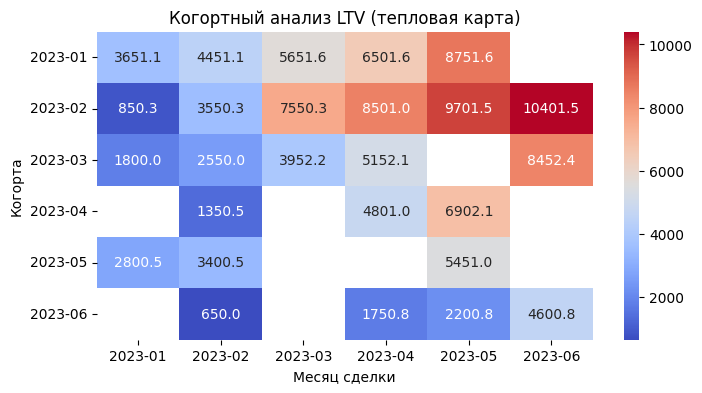

In [44]:
pivot_df = df.pivot(
    index="cohort_month", 
    columns="sale_month", 
    values="cumulative_sales"
)

plt.figure(figsize=(8, 4))
sns.heatmap(
    pivot_df, 
    annot=True, 
    fmt=".1f", 
    cmap="coolwarm"
)
plt.title("Когортный анализ LTV (тепловая карта)")
plt.xlabel("Месяц сделки")
plt.ylabel("Когорта")
plt.show()

Теоретически здесь должна быть красивая ступенчатая тепловая карта с кумулятивным LTV, но, поскольку данные в таблицах синтетические, получилось то, что получилось)<br><br>
Визуализируем распределение пользователей по сегментам активности.

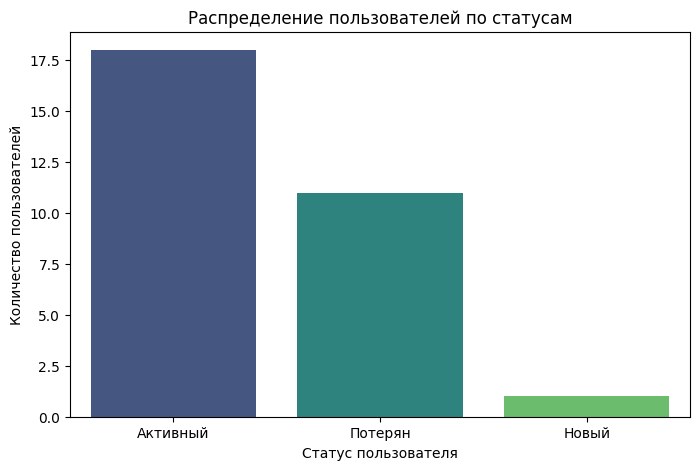

In [8]:
cursor.execute("""
    SELECT status, COUNT(user_id) AS count_users
    FROM users
    GROUP BY status
    ORDER BY count_users DESC;
""")

results = cursor.fetchall()
df = pd.DataFrame(results, columns=['status', 'count_users'])

plt.figure(figsize=(8, 5))
sns.barplot(
    x="status", 
    y="count_users", 
    hue="status", 
    data=df, 
    palette="viridis"
)
plt.title("Распределение пользователей по статусам")
plt.xlabel("Статус пользователя")
plt.ylabel("Количество пользователей")
plt.xticks(rotation=0)
plt.show()

Посчитаем Retention Rate (Процент удержания по когортам), который выводится как (Число клиентов, совершивших повторную покупку​ / Общее число клиентов в когорте) * 100

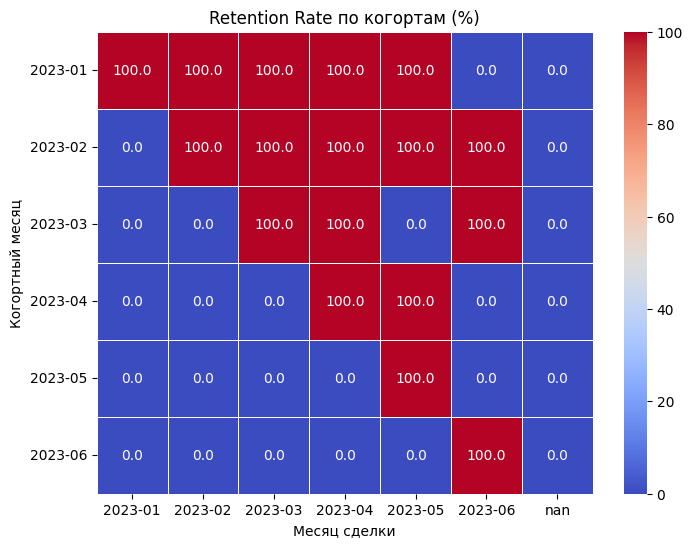

In [41]:
query = """
    WITH cohort_users AS (
        SELECT user_id, MIN(DATE_TRUNC('month', first_action_date)) AS cohort_month
        FROM users
        GROUP BY user_id
    ),
    repeat_customers AS (
        SELECT u.user_id, c.cohort_month, DATE_TRUNC('month', s.deal_date) AS sale_month
        FROM users AS u
        JOIN sales AS s ON u.user_id = s.user_id
        JOIN cohort_users AS c ON u.user_id = c.user_id
        WHERE s.deal_date >= c.cohort_month
    )
    SELECT 
        c.cohort_month,
        r.sale_month,
        COUNT(DISTINCT r.user_id) * 100.0 / COUNT(DISTINCT c.user_id) AS retention_rate
    FROM cohort_users AS c
    LEFT JOIN repeat_customers AS r ON c.user_id = r.user_id
    GROUP BY c.cohort_month, r.sale_month
    ORDER BY c.cohort_month, r.sale_month;
"""

cursor.execute(query)
results = cursor.fetchall()

df_rr = pd.DataFrame(
    results, 
    columns=['cohort_month', 'sale_month', 'retention_rate']
)

df_rr['cohort_month'] = df_rr['cohort_month'].astype(str)
df_rr['sale_month'] = df_rr['sale_month'].astype(str)

df_pivot = df_rr.pivot(
    index="cohort_month", 
    columns="sale_month", 
    values="retention_rate"
)

df_pivot = df_pivot.fillna(0)
df_pivot = df_pivot.astype(float)
df_pivot.index = pd.to_datetime(df_pivot.index).strftime('%Y-%m')  
df_pivot.columns = pd.to_datetime(df_pivot.columns).strftime('%Y-%m')  

plt.figure(figsize=(8, 6))
sns.heatmap(
    df_pivot, 
    annot=True, 
    fmt=".1f", 
    cmap="coolwarm", 
    linewidths=0.5
)
plt.yticks(rotation=0)  
plt.title("Retention Rate по когортам (%)")
plt.xlabel("Месяц сделки")
plt.ylabel("Когортный месяц")
plt.show()

С этой таблицей также проблемы ввиду неорганичности данных, но в целом принцип такой.<br><br>

Выделим долю активных пользователей.

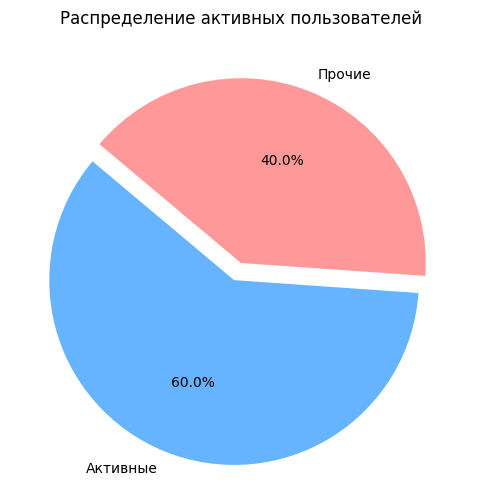

In [40]:
query = """
SELECT 
    COUNT(
        CASE 
            WHEN status = 'Активный' THEN 1 
        END
        ) * 100.0 / COUNT(user_id) AS active_users_pct
FROM users;
"""

cursor.execute(query)
result = cursor.fetchone()

active_users_pct = result[0]
other_users_pct = 100 - active_users_pct 

labels = ['Активные', 'Прочие']
sizes = [active_users_pct, other_users_pct]
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0) 


plt.figure(figsize=(6, 6))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    colors=colors, 
    explode=explode, 
    startangle=140
)
plt.title("Распределение активных пользователей")
plt.show()
